<div class="usecase-title">Tourism Impact Analysis</div>

<div class="usecase-authors"><b>Authored by: </b> Taehwan Jung</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Haversine Distance, Folium Maps </div>
</div>

**Scenario**

Understanding how tourists impact various regions of the city is important for enhancing tourism strategies and effectively addressing transportation and environmental challenges. The primary objective is to analyze pedestrian data to estimate the influence of tourists in different areas. By quantifying the impact of tourists on pedestrian activity, the city aims to make informed decisions that will improve urban planning, optimize resource allocation, and enhance the overall experience for both residents and visitors.

**User story**

As a city planner for Melbourne, I want to understand how tourists impact various regions of the city so that I can improve urban planning and optimize resource allocation needed for maintaining transportation and environmental sustainability.

What this use case will teach me is

At the end of this use case you will:
- learn how to load datasets using APIs
- learn how to create maps and visualize data
- learn how to analyze data relationship using correlation and regression analysis
- learn how to analyze data using Arima and clustering techniques


**Datasets**

**1. Pedestrian Counting per Hour:**
Contains hourly data on the number of pedestrians counted at various sensor locations throughout Melbourne, including sensor IDs, timestamps, and location details.

**2. Bus Stops for Melbourne Visitor Shuttles:** Provides information on the locations of bus stops used by the Melbourne Visitor Shuttle service, including stop numbers, names, addresses, and coordinates.

**3. Public Artworks, Fountains, and Monuments:** Includes details about public artworks, fountains, and monuments across Melbourne, such as their names, asset types, artist information, and location coordinates.

**4. Domestic Visitor:** Contains data on domestic overnight visitors to Melbourne, including the number of visitors to Melbourne and regional Victoria, segmented by year and quarter.

## **Required modules**


In [5]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
from folium.plugins import MarkerCluster
from folium.plugins import feature_group_sub_group
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.cluster import KMeans
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## **Data loading**


In [3]:
# Collect_data function
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    dataset_id = dataset_id
    format = 'csv'


    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
    }

    response = requests.get(url, params=params)


    if response.status_code == 200:
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

Data1 (Pedestrian counting data) loading

In [4]:
# Pedestrian counting data
dataset_id = 'pedestrian-counting-system-monthly-counts-per-hour'
data_1 = collect_data(dataset_id)
data_1.shape

(1850393, 9)

Data2 (Bus stops for Melbourne Visitor Shuttle) loading

In [6]:
# Bus stop for Melbourne visitor shuttle data
dataset_id_2 = 'bus-stops-for-melbourne-visitor-shuttle'
data_2 = collect_data(dataset_id_2)
data_2.shape

(13, 4)

Data3 (Public artworks, fountains, and monuments) loading

In [7]:
# Public artworks, fountains, and monuments data
dataset_id_3 = 'public-artworks-fountains-and-monuments'
data_3 = collect_data(dataset_id_3)
data_3.shape

(261, 14)

Data4 (Domestic visitors) loading

In [8]:
# Domestic visitor data from visit victoria
#data_4 = pd.read_csv('/content/sample_data/Domestic overnight visitors.csv')
data_4 = pd.read_csv('https://raw.githubusercontent.com/Chameleon-company/MOP-Code/taehwan/datascience/usecases/DEPENDENCIES/Domestic_overnight_visitors.csv')
data_4.shape

(41, 3)

## **Data preprocessing**

In [9]:
# Drop unnecessary features
data_3_cleaned = data_3.drop(columns=['easting', 'northing','xorg','xsource','artist','art_date','respective_author', 'structure', 'alternate_name'])
data_3_cleaned.head()

,asset_type,name,address_point,mel_way_ref,co_ordinates
0,Art,Blowhole,"13 Harbour Esplanade, DOCKLANDS",2E_G8,"-37.8220182164578, 144.946871022845"
1,Art,Bandstand,"200 Little Collins Street, MELBOURNE",2F_G3,"-37.8140548689972, 144.96733868317"
2,Art,Federation Bells,"Birrarung Marr, MELBOURNE",2F_ K6,"-37.8186738864394, 144.974167165492"
3,Art,Coat of Arms,"98 Swanston Street, MELBOURNE",2F_F4,"-37.8151582937289, 144.966495940551"
4,Monument,Edmund Fitzgibbon Memorial,"208 St Kilda Road, SOUTHBANK",2F_H9,"-37.8236122113264, 144.970418561306"


Remove unnecessary columns from the tourist spots dataset

In [10]:
# Na values check
data_1.isna().sum()
data_2.isna().sum()
data_3_cleaned.isna().sum()
data_4.isna().sum()

,0
DateTime,0
Melbourne,0
Regional VIC,0


Check if there are missing values in each dataset

In [11]:
# To pandas datetime type
data_1_1 = data_1
data_1_1['sensing_date'] = pd.to_datetime(data_1['sensing_date'])
data_1_1['year_month'] = data_1_1['sensing_date'].dt.to_period('M').dt.end_time.dt.date
# Summing 'pedestriancount' by 'sensor_name', 'year_month', and 'location'
data_1_1 = data_1_1.groupby(['sensor_name', 'year_month', 'location']).agg({
    'pedestriancount': 'sum'
}).reset_index()
# Checking conversion
data_1_1.head()

,sensor_name,year_month,location,pedestriancount
0,261Will_T,2022-11-30,"-37.81295822, 144.95678789",91518
1,261Will_T,2022-12-31,"-37.81295822, 144.95678789",50214
2,261Will_T,2023-01-31,"-37.81295822, 144.95678789",38818
3,261Will_T,2023-05-31,"-37.81295822, 144.95678789",216910
4,261Will_T,2023-06-30,"-37.81295822, 144.95678789",288651


Convert the date type to a pandas datetime format and aggregate the data on a monthly basis

In [12]:
# Data_1 (pedestrian data) filtering for regression analysis
data_1_2 = data_1[data_1['sensing_date'].dt.year.isin([2021, 2022, 2023, 2024])]
data_1_2.head()
# 'sorting 'sensing_date' by quarter
data_1_2['year_quarter'] = data_1_2['sensing_date'].dt.to_period('Q')
# Summing 'pedestriancount' by 'year_quarter'
data_1_2 = data_1_2.groupby(['year_quarter']).agg({
    'pedestriancount': 'sum'
}).reset_index()
# Checking conversion
data_1_2.head()

,year_quarter,pedestriancount
0,2021Q3,19152943
1,2021Q4,33159337
2,2022Q1,37898480
3,2022Q2,46924338
4,2022Q3,48843359


Aggregate the pedestrian data quarterly. It will be used later in regression analysis

In [13]:
# Data_1 filtering for Time series
data_1_3 = data_1
data_1_3['year_day'] = data_1_3['sensing_date'].dt.to_period('D').dt.end_time.dt.date
# Summing 'pedestriancount' by 'sensor_name', 'year_month', and 'location'
data_1_3 = data_1_3.groupby(['sensor_name', 'year_day', 'location']).agg({
    'pedestriancount': 'sum'
}).reset_index()
data_1_3.head()

,sensor_name,year_day,location,pedestriancount
0,261Will_T,2022-11-17,"-37.81295822, 144.95678789",3993
1,261Will_T,2022-11-18,"-37.81295822, 144.95678789",11594
2,261Will_T,2022-11-19,"-37.81295822, 144.95678789",3200
3,261Will_T,2022-11-20,"-37.81295822, 144.95678789",2855
4,261Will_T,2022-11-21,"-37.81295822, 144.95678789",11506


Aggregate the pedestrian data daily. It will be used later in Time Series analysis

In [14]:
# Convert datatype of 'data_4'(visitor_count data)
# To pandast datetime type
data_4['DateTime'] = pd.to_datetime(data_4['DateTime'])
# Data filtering
data_4_filtered = data_4[data_4['DateTime'].dt.year.isin([2021, 2022, 2023, 2024])]
data_4_filtered['DateTime'] = data_4_filtered['DateTime'].dt.to_period('Q')
data_4_filtered['year_quarter'] = data_4_filtered['DateTime']
# Dropping unecessary column
data_4_filtered = data_4_filtered.drop('DateTime',axis=1)
data_4_filtered = data_4_filtered.drop('Regional VIC',axis=1)
data_4_filtered = data_4_filtered.rename(columns={'Melbourne': 'visitor_count'})
# Checking result
data_4_filtered.head()

,visitor_count,year_quarter
28,2593347,2021Q1
29,3768841,2021Q2
30,4040786,2021Q3
31,4361704,2021Q4
32,4647179,2022Q1


Aggregate the tourist data quarterly. It will be used in regression analysis

In [15]:
# Create columns of 'latitude'and 'longitude' for folium mapping
# data_1_1
data_1_1[['latitude', 'longitude']] = data_1_1['location'].str.split(',', expand=True)
data_1_1['latitude'] = pd.to_numeric(data_1_1['latitude'], errors='coerce')
data_1_1['longitude'] = pd.to_numeric(data_1_1['longitude'], errors='coerce')
# data_1_3
data_1_3[['latitude', 'longitude']] = data_1_3['location'].str.split(',', expand=True)
data_1_3['latitude'] = pd.to_numeric(data_1_3['latitude'], errors='coerce')
data_1_3['longitude'] = pd.to_numeric(data_1_3['longitude'], errors='coerce')
#data_2
data_2[['latitude', 'longitude']] = data_2['co_ordinates'].str.split(',', expand=True)
data_2['latitude'] = pd.to_numeric(data_2['latitude'], errors='coerce')
data_2['longitude'] = pd.to_numeric(data_2['longitude'], errors='coerce')
#data_3_cleaned
data_3_cleaned[['latitude', 'longitude']] = data_3_cleaned['co_ordinates'].str.split(',', expand=True)
data_3_cleaned['latitude'] = pd.to_numeric(data_3_cleaned['latitude'], errors='coerce')
data_3_cleaned['longitude'] = pd.to_numeric(data_3_cleaned['longitude'], errors='coerce')
data_3_cleaned['latitude'] = data_3_cleaned['latitude'].astype(float)
data_3_cleaned['longitude'] = data_3_cleaned['longitude'].astype(float)
#Checking results
print(data_1_3.head())

  sensor_name    year_day                    location  pedestriancount  \
0   261Will_T  2022-11-17  -37.81295822, 144.95678789             3993   
1   261Will_T  2022-11-18  -37.81295822, 144.95678789            11594   
2   261Will_T  2022-11-19  -37.81295822, 144.95678789             3200   
3   261Will_T  2022-11-20  -37.81295822, 144.95678789             2855   
4   261Will_T  2022-11-21  -37.81295822, 144.95678789            11506   

    latitude   longitude  
0 -37.812958  144.956788  
1 -37.812958  144.956788  
2 -37.812958  144.956788  
3 -37.812958  144.956788  
4 -37.812958  144.956788  


Create latitude and longitude columns for each dataset

# Data visualization

In [ ]:
# Merge Pedestrian Data and Tourist Attraction Data on a Map
# Creating a map
map_melbourne = folium.Map(location=[-37.80841814,144.95906317], zoom_start=14, width=1000, height=600, control_scale=True)
# Pedestrian data
for index, row in data_1_1.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Location: {row['sensor_name']}<br>Count: {row['pedestriancount']}",
    ).add_to(map_melbourne)

# Tourist spots data
for index, row in data_3_cleaned.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Name: {row['name']}<br>Type: {row['asset_type']}",
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(map_melbourne)

# Adding a legend
legend_html = '''
<div style="position: fixed;
     top: 10px; left: 10px; width: 150px; height: 90px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color: white; padding: 10px;">
     <b>Legend</b><br>
     <i style="color:blue;" class="fa fa-circle"></i> Pedestrian Count Sensor Locations<br>
     <i style="color:green;" class="fa fa-info-circle"></i> Tourist Spots</div>
'''
map_melbourne.get_root().html.add_child(folium.Element(legend_html))

# Map displaying
map_melbourne.save('melbourne_map.html')
display(map_melbourne)

The map above visually represent the correlation between the pedestrian data and tourist spots data

   year_quarter  pedestriancount  visitor_count
0        2021Q3         19152943        4040786
1        2021Q4         33159337        4361704
2        2022Q1         37898480        4647179
3        2022Q2         46924338        5400025
4        2022Q3         48843359        7219067
5        2022Q4         54960213        8556485
6        2023Q1         57335887        9419538
7        2023Q2         58063867        9829835
8        2023Q3         63283379       10084297
9        2023Q4         70728077       10257111
10       2024Q1         69336334       10365636


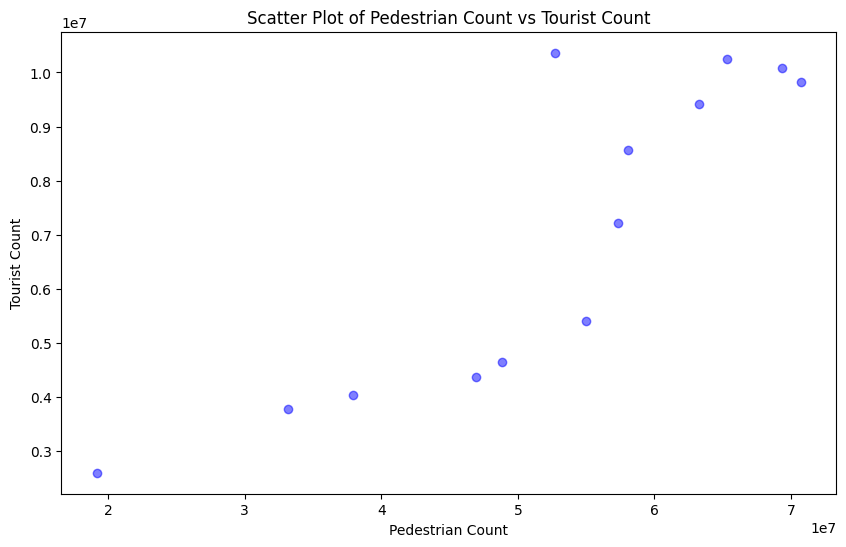

In [17]:
# Dataset merge for scatter plot
merged_data_1 = pd.merge(data_1_2, data_4_filtered, on='year_quarter', how='inner')
# Merged_data checking
print(merged_data_1)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data_1_2['pedestriancount'], data_4_filtered['visitor_count'], color='blue', alpha=0.5)
plt.title('Scatter Plot of Pedestrian Count vs Tourist Count')
plt.xlabel('Pedestrian Count')
plt.ylabel('Tourist Count')
plt.show()

The scatter plot above shows the linear relationship between the pedestrian data and tourist data

# Data analysis

**Pearson Correalation Analysis**

In [18]:
# Pearson Correlation Analysis(Pedestrian counting dataset and tourist dataset)
correlation = merged_data_1['pedestriancount'].corr(merged_data_1['visitor_count'])
print(f"Pearson Correlation Coefficient: {correlation}")

Pearson Correlation Coefficient: 0.9384815117290771


Conduct a Pearson correlation coefficient analysis on the total pedestrian data and tourist data for the same period. The result is very high, indicating a strong correlation.

**Regression Analysis**

In [19]:
# Regression model
# 'fpedestriancount' is independent variable, 'visitor_count' is dependent variable
X = merged_data_1[['pedestriancount']]
y = merged_data_1['visitor_count']
# Dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Regression model fit
model = LinearRegression()
model.fit(X_train, y_train)
# Regression model predict
y_pred = model.predict(X_test)
r_squared = model.score(X, y)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
# Regression model results
print(merged_data_1)
print(f"Regression Coefficient: {model.coef_}")
print(f"R-squared: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error (MSE): {mse}")

   year_quarter  pedestriancount  visitor_count
0        2021Q3         19152943        4040786
1        2021Q4         33159337        4361704
2        2022Q1         37898480        4647179
3        2022Q2         46924338        5400025
4        2022Q3         48843359        7219067
5        2022Q4         54960213        8556485
6        2023Q1         57335887        9419538
7        2023Q2         58063867        9829835
8        2023Q3         63283379       10084297
9        2023Q4         70728077       10257111
10       2024Q1         69336334       10365636
Regression Coefficient: [0.19797284]
R-squared: 0.8006500040727327
Mean Absolute Error: 1423366.9560733212
Mean Squared Error (MSE): 3168240628361.365


Base on the Pearson correlation coefficient result indicating a strong correlation, conduct a regression analysis of the two datasets. Examine the regression coefficient to determine the relationship between the pedestrian data and tourist data, and review the MAE, MSE, and R-squared results to verify the accuracy of the analysis.

**Estimation of Regional Tourist Numbers Using the Regression Coefficient**

In [20]:
# Regression_coefficient
regression_coefficient = 0.198
# Estimation regional tourists numbers
data_1_1_estimation = data_1_1.copy()
data_1_1_estimation['estimated_tourist_count'] = data_1_1['pedestriancount'] * regression_coefficient
print(data_1_1_estimation.head(10))
print(data_1_1_estimation.shape)

  sensor_name  year_month                    location  pedestriancount  \
0   261Will_T  2022-11-30  -37.81295822, 144.95678789            91518   
1   261Will_T  2022-12-31  -37.81295822, 144.95678789            50214   
2   261Will_T  2023-01-31  -37.81295822, 144.95678789            38818   
3   261Will_T  2023-05-31  -37.81295822, 144.95678789           216910   
4   261Will_T  2023-06-30  -37.81295822, 144.95678789           288651   
5   261Will_T  2023-07-31  -37.81295822, 144.95678789           314142   
6   261Will_T  2023-08-31  -37.81295822, 144.95678789           343645   
7   261Will_T  2023-09-30  -37.81295822, 144.95678789           303683   
8   261Will_T  2023-10-31  -37.81295822, 144.95678789           328492   
9   261Will_T  2023-11-30  -37.81295822, 144.95678789           316824   

    latitude   longitude  estimated_tourist_count  
0 -37.812958  144.956788                18120.564  
1 -37.812958  144.956788                 9942.372  
2 -37.812958  144.956788     

Use the regression coefficient to extract the proportion of tourists for each sensor from the pedestrian data.

**Matching the closest pedestrian counting sensor to a tourist spot**

In [22]:
# Calculating the distance between the sensor location and tourist spots location using Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c
# Matching tourist spots and the neartest sensor location
def match_closest_pedestrian_data(tourist_data, pedestrian_data):
    matches = []

    for _, tour_row in tourist_data.iterrows():
        min_distance = float('inf')
        closest_pedestrian = None

        for _, ped_row in pedestrian_data.iterrows():
            distance = haversine(tour_row['latitude'], tour_row['longitude'], ped_row['latitude'], ped_row['longitude'])
            if distance < min_distance:
                min_distance = distance
                closest_pedestrian = ped_row
        estimated_tourist_count = closest_pedestrian['pedestriancount'] * regression_coefficient

        matches.append({
            'tourist_location': tour_row['name'],
            'pedestrian_sensor': closest_pedestrian['sensor_name'],
            'pedestrian_count': closest_pedestrian['pedestriancount'],
            'distance_km': min_distance,
            'tour_latitude' : tour_row['latitude'],
            'tour_longitude' : tour_row['longitude'],
            'estimated_tourist_count' : estimated_tourist_count,
            })

    return pd.DataFrame(matches)
# Matching results
matched_data = match_closest_pedestrian_data(data_3_cleaned, data_1_1_estimation)
print(matched_data)

                tourist_location pedestrian_sensor  pedestrian_count  \
0                       Blowhole           WebBN_T             80218   
1                      Bandstand          Bou231_T            178078   
2               Federation Bells      BirFed1120_T             88316   
3                   Coat of Arms          Swa123_T            257070   
4     Edmund Fitzgibbon Memorial             VAC_T            378528   
..                           ...               ...               ...   
256       Dinny O'Hearn Fountain          Lyg309_T            110294   
257  Westgarth Drinking Fountain          Spr201_T             68561   
258     Pioneer Women's Memorial             VAC_T            378528   
259                Painted Poles           SwaCs_T            152538   
260                        Angel      BirFed1120_T             88316   

     distance_km  tour_latitude  tour_longitude  estimated_tourist_count  
0       0.105429     -37.822018      144.946871             

Match each tourist spot with the nearest pedestrian sensor to estimate the number of tourists.

**Time series prediction**

In [23]:
# Preprocessing for time series prediction
data_1_3_estimation = data_1_3.copy()
data_1_3_estimation['year_day'] = pd.to_datetime(data_1_3_estimation['year_day'])
data_1_3_estimation['estimated_tourist_count'] = data_1_3['pedestriancount'] * regression_coefficient
# Drop duplicate sensor 'BirBridge_T'
data_1_3_estimation = data_1_3_estimation[data_1_3_estimation['sensor_name'] != 'BirBridge_T']

In [ ]:
# ARIMA model
results = []
sensor_groups = data_1_3_estimation.groupby('sensor_name')
# Time serires model fit and forcast for each areas
for sensor_name, group in sensor_groups:
    if len(group) >= 10:
        print(f"Processing sensor: {sensor_name}")
        ts_data = group.set_index('year_day')['estimated_tourist_count']
        ts_data = ts_data.asfreq('D')
        ts_data = ts_data.ffill()
        ts_data = ts_data.astype(int)

        # Data split
        train_size = int(len(ts_data) * 0.7)
        train, test = ts_data[:train_size], ts_data[train_size:]

        # SARIMA
        model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
        # model = ARIMA(train, order=(3, 1, 2)) Arima model
        model_fit = model.fit()

        # Prediction for test data
        forecast = model_fit.forecast(steps=len(test))

        # RMSE
        rmse = np.sqrt(mean_squared_error(test, forecast))

        # Forcast_increase
        forecast_increase = forecast.iloc[-1] - forecast.iloc[0]

        # AIC, BIC
        aic = model_fit.aic
        bic = model_fit.bic
        print(f"AIC for sensor {sensor_name}: {aic}")
        print(f"BIC for sensor {sensor_name}: {bic}")

        # Results
        results.append({
            'sensor_name': sensor_name,
            'rmse': rmse,
            'forecast_increase': forecast_increase,
        })

        # Results print
        print(f"RMSE for sensor {sensor_name}: {rmse}")
        print(f"Forecast for sensor {sensor_name}:\n{forecast}\n")
        print(f"Forecast Increase for sensor {sensor_name}: {forecast_increase}\n")

        # Visualization
        plt.figure(figsize=(10, 6))
        plt.plot(train.index, train, label='Training Data')
        plt.plot(test.index, test, label='Test Data', color='green')
        plt.plot(test.index, forecast, label='Forecast', color='red')
        plt.title(f'Forecast for Sensor {sensor_name}')
        plt.xlabel('Date')
        plt.ylabel('Estimated Tourist Count')
        plt.legend()
        plt.show()


    else:
        print(f"Skipping sensor {sensor_name} due to insufficient data.")

# result
results_df = pd.DataFrame(results)

Perform time series prediction for each sensor using daily pedestrian data and the estimated tourist data.

In [25]:
# Filtering the top 10 sensors
top_10 = results_df.sort_values(by='rmse').nlargest(10, 'forecast_increase')
print(top_10)

   sensor_name         rmse  forecast_increase
23    Col700_T  1753.170327        3023.296543
63      RMIT_T  1659.274072        2049.594714
60       QVN_T  1170.318378        1466.542436
21    Col620_T   976.372848        1394.464178
76       Swa31  4153.878751        1290.145887
24      ElFi_T  1069.836633        1161.107265
55      MCEC_T  1379.774349        1106.678755
73    Swa123_T  1626.819741        1100.877376
25    Eli250_T  1075.237477         964.489569
75    Swa295_T  1479.962155         922.407188


List the top 10 sensors where the number of tourists is expected to increase the most by calculating the difference between the first and last predicted values.

In [26]:
# 'top_10_results'
data_for_join  = data_1_1_estimation.drop_duplicates(subset=['sensor_name'], keep='first')
# 'left join'
top_10_results = pd.merge(top_10, data_for_join, on='sensor_name', how='left')
print(top_10_results)

  sensor_name         rmse  forecast_increase  year_month  \
0    Col700_T  1753.170327        3023.296543  2021-07-31   
1      RMIT_T  1659.274072        2049.594714  2021-07-31   
2       QVN_T  1170.318378        1466.542436  2021-07-31   
3    Col620_T   976.372848        1394.464178  2021-07-31   
4       Swa31  4153.878751        1290.145887  2021-07-31   
5      ElFi_T  1069.836633        1161.107265  2021-07-31   
6      MCEC_T  1379.774349        1106.678755  2021-07-31   
7    Swa123_T  1626.819741        1100.877376  2021-07-31   
8    Eli250_T  1075.237477         964.489569  2021-07-31   
9    Swa295_T  1479.962155         922.407188  2021-07-31   

                     location  pedestriancount   latitude   longitude  \
0  -37.81982992, 144.95102555            82497 -37.819830  144.951026   
1  -37.80825648, 144.96304859           137066 -37.808256  144.963049   
2  -37.81057846, 144.96444294           327068 -37.810578  144.964443   
3  -37.81887963, 144.95449198       

Rematch the top_10 results with location , the pedestrian couting, and estimated tourist couting data.

In [27]:
# 'Find the closest tourist location for each sensor based on 'top_10_results'
matching_results = []

# 'top_10_results'
for i, row_sensor in top_10_results.iterrows():
    min_distance = float('inf')
    closest_location = None
    closest_arttype = None
    closest_lat = None
    closest_lon = None

    # 'tourist spots'
    for j, row_tourist in data_3_cleaned.iterrows():
        distance = haversine(row_sensor['latitude'], row_sensor['longitude'],
                             row_tourist['latitude'], row_tourist['longitude'])

        # updating tourist spots
        if distance < min_distance:
            min_distance = distance
            closest_location = row_tourist['name']
            closest_arttype = row_tourist['asset_type']
            closest_lat = row_tourist['latitude']
            closest_lon = row_tourist['longitude']

    # Save results
    matching_results.append({
        'sensor_name': row_sensor['sensor_name'],
        'sensor_latitude': row_sensor['latitude'],
        'sensor_longitude': row_sensor['longitude'],
        'closest_tourist_location': closest_location,
        'arttype': closest_arttype,
        'tourist_latitude': closest_lat,
        'tourist_longitude': closest_lon,
        'distance_km': min_distance
    })

# Printing result
matching_results_df = pd.DataFrame(matching_results)
print(matching_results_df)

  sensor_name  sensor_latitude  sensor_longitude  \
0    Col700_T       -37.819830        144.951026   
1      RMIT_T       -37.808256        144.963049   
2       QVN_T       -37.810578        144.964443   
3    Col620_T       -37.818880        144.954492   
4       Swa31       -37.816686        144.966897   
5      ElFi_T       -37.817980        144.965034   
6      MCEC_T       -37.824018        144.956044   
7    Swa123_T       -37.814880        144.966088   
8    Eli250_T       -37.812585        144.962578   
9    Swa295_T       -37.811015        144.964295   

          closest_tourist_location   arttype  tourist_latitude  \
0                        Feng Shui       Art        -37.819823   
1           Architectural Fragment       Art        -37.809828   
2                    Painted Poles       Art        -37.810347   
3                            Eagle       Art        -37.820725   
4    Beyond the Ocean of Existence       Art        -37.816424   
5  Captain Matthew Flinders Sta

Match the top_10 sensors with the closest tourist spots.

In [ ]:
# color list for matched data
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
          'beige', 'darkblue', 'darkgreen']

# Creating a map
map_top_10 = folium.Map(location=[-37.80841814, 144.95906317], zoom_start=14, width=1000, height=600, control_scale=True)
# top_10_results
for index, row in matching_results_df.iterrows():
    color = colors[index % len(colors)]
    # sensor_location
    folium.CircleMarker(
        location=[row['sensor_latitude'], row['sensor_longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"Sensor: {row['sensor_name']}<br>Count: {row['distance_km']:.2f} km to closest tourist spot",
    ).add_to(map_top_10)

    # tourist spots
    folium.Marker(
        location=[row['tourist_latitude'], row['tourist_longitude']],
        popup=f"Name: {row['closest_tourist_location']}<br>Type: {row['arttype']}",
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(map_top_10)


# Adding a legend
legend_html_2 = '''
<div style="position: fixed;
     top: 10px; left: 10px; width: 150px; height: 90px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color: white; padding: 10px;">
     <b>Legend</b><br>
     <i style="color:green;" class="fa fa-circle"></i> Nearest Sensor to Tourist Spot<br>
     <i style="color:green;" class="fa fa-info-circle"></i> Top 10 Tourist Spots</div>
'''
map_top_10.get_root().html.add_child(folium.Element(legend_html_2))

# Map save
map_top_10.save('map_top_10.html')
# Display map
display(map_top_10)

Visualize the matching of top_10 sensors and tourist spots on a map.

**K-means clustering**

In [29]:
# Aggregate by sensor_name and calculate the total.
data_1_1_estimation_sum = data_1_1_estimation.groupby('sensor_name').agg({
    'pedestriancount': 'sum',
    'estimated_tourist_count': 'sum',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

print(data_1_1_estimation_sum)

   sensor_name  pedestriancount  estimated_tourist_count   latitude  \
0    261Will_T          4654198               921531.204 -37.812958   
1    280Will_T          2118083               419380.434 -37.812463   
2      474Fl_T          1255299               248549.202 -37.819973   
3     488Mac_T          1973997               390851.406 -37.794324   
4     574Qub_T          1302639               257922.522 -37.803100   
..         ...              ...                      ...        ...   
83       VAC_T         17932918              3550717.764 -37.821299   
84       Vic_T          3242335               641982.330 -37.806069   
85    WatCit_T          3109574               615695.652 -37.815650   
86     WebBN_T          4883437               966920.526 -37.822935   
87    WestWP_T           771742               152804.916 -37.812358   

     longitude  
0   144.956788  
1   144.956902  
2   144.958349  
3   144.929734  
4   144.949081  
..         ...  
83  144.968793  
84  144.956

In [30]:
# Min-Max normalization
scaler = MinMaxScaler()
data_1_1_estimation_sum[['pedestriancount', 'estimated_tourist_count']] = scaler.fit_transform(data_1_1_estimation_sum[['pedestriancount', 'estimated_tourist_count']])

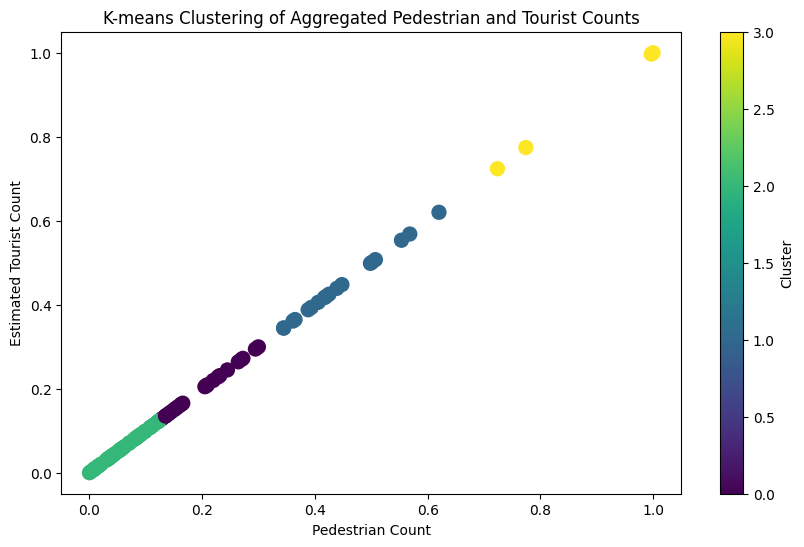

Silhouette Score: 0.58


In [31]:
data_1_1_estimation_cluster = data_1_1_estimation_sum.copy()
X = data_1_1_estimation_cluster[['pedestriancount', 'estimated_tourist_count']]

# K-means clustering model
kmeans = KMeans(n_clusters=4, random_state=0)
data_1_1_estimation_cluster['cluster'] = kmeans.fit_predict(X)

# visualization
plt.figure(figsize=(10, 6))
plt.scatter(data_1_1_estimation_cluster['pedestriancount'], data_1_1_estimation_cluster['estimated_tourist_count'],
            c=data_1_1_estimation_cluster['cluster'], cmap='viridis', s=100)
plt.xlabel('Pedestrian Count')
plt.ylabel('Estimated Tourist Count')
plt.title('K-means Clustering of Aggregated Pedestrian and Tourist Counts')
plt.colorbar(label='Cluster')
plt.show()

from sklearn.metrics import silhouette_score
score = silhouette_score(X, data_1_1_estimation_cluster['cluster'])
print(f'Silhouette Score: {score:.2f}')

Perform K-means clustering to visually identify patterns in the relationship between pedestrian count and estimated tourist count.

In [ ]:
# K-means
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
data_1_1_estimation_cluster['cluster'] = kmeans.fit_predict(data_1_1_estimation_cluster[['pedestriancount', 'estimated_tourist_count']])

# color list
colors = [ 'purple', 'blue', 'green', 'yellow']

# Creating a map
map_clusters = folium.Map(location=[-37.8136, 144.9631], zoom_start=14, width=1000, height=600, control_scale=True)
for index, row in data_1_1_estimation_cluster.iterrows():
    color = colors[row['cluster']]

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=7,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"Sensor: {row['sensor_name']}<br>Cluster: {row['cluster']}<br>Pedestrian Count: {row['pedestriancount']}<br>Estimated Tourist Count: {row['estimated_tourist_count']}"
    ).add_to(map_clusters)

# Adding a legend
legend_html_3 = '''
<div style="position: fixed;
     top: 10px; left: 10px; width: 200px; height: 120px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color: white; padding: 10px;">
     <b>Legend</b><br>
     <i style="color:yellow;" class="fa fa-circle"></i> Cluster 0: Most crowded<br>
     <i style="color:blue;" class="fa fa-circle"></i> Cluster 1: Second<br>
     <i style="color:purple;" class="fa fa-circle"></i> Cluster 2: Third<br>
     <i style="color:green;" class="fa fa-circle"></i> Cluster 3: Least
</div>
'''

map_clusters.get_root().html.add_child(folium.Element(legend_html_3))


# Displying the map
map_clusters.save('map_clusters.html')
display(map_clusters)

Apply K-means clustering on a map to identify patterns in specific areas.

In [34]:
# Mean value of each cluster
cluster_means = data_1_1_estimation_cluster.groupby('cluster')[['estimated_tourist_count']].mean()
# Result
print(cluster_means)

         estimated_tourist_count
cluster                         
0                       0.196986
1                       0.444419
2                       0.057633
3                       0.873733


The clusters are in the order of yellow, blue, purple, and green, starting from cluster 0. Check the mean values for each cluster to understand their characteristics.

# Conclusion

**Findings**



  There was a strong correlation between the sum of pedestrian counts from all sensors and the total number of tourists in Melbourne. While this might seem like an expected result, the fact that the ratio is consistently similar is a meaningful finding, especially considering the difficulty of extracting only the tourist numbers from the data.



  The time series prediction results indicate that the top 10 areas with the highest expected increase in tourists are mostly around Swanston Street and Flinders Street Station. The clustering results also show that the two clusters with the highest number of tourists are primarily located around Swanston Street, Flinders Street Station, and Southern Cross Station.

**Limitations**


   To accurately determine the number of tourists in each area, I understand that various factors, such as local events, specific characteristics, and weather conditions, can significantly affect tourist numbers. However, because of the limited availability of such data, I had to rely solely on pedestrian counts from each sensor and the total number of tourists in Melbourne, which introduces clear limitations to the accuracy of our findings.


  The definition and scope of 'tourist spots' are somewhat vague. The data includes various fountains, monuments, and other sites in the Melbourne CBD, but we cannot assume that tourists visit these areas only for these attractions. This makes it difficult to determine how much these locations actually attract tourists. Additionally, because tourists may have different reasons or purposes for visiting, the lack of a clear definition of 'tourist spots' makes it hard to understand their true movement patterns.



#References

[1] Sheng, Q., Jiao, J., & Pang, T. (2021). Understanding the impact of street patterns on pedestrian distribution: A case study in Tianjin, China. https://link.springer.com/article/10.1007/s40864-021-00152-9#Sec9

[2] Fu, L., Yao, Y., Liu, L., & Chen, R. (2024). Study on influencing factors of tourist flow in scenic spots based on big data. https://www.researchsquare.com/article/rs-3201240/v1

[3] Visit Victoria. (2024). Visit Victoria. https://www.visitvictoria.com/